In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import argparse
from IPython.display import clear_output

f = 567.2
b = 92.226
z = []

In [2]:
def distanceZframe(disparity):
    #Estimate a main disparity
    d = np.average(disparity) 
    #Determine the distance in mm
    z=(b*f)/d #mm
    #convert in m
    z_m = z/1000 #m
    
    return z_m

In [3]:
#Compute disparity map
index = []
def computeDisparityMap(videoL, videoR, numDisp=16, blockSize=17):
    i=0
    try:
        #comute all frames of video
        while(videoL.isOpened() and videoR.isOpened()):
            #extract frames
            retL, frameL = videoL.read()
            retR, frameR = videoR.read()
            
            #check frames
            if not retL or frameL is None or  not retR or frameR is None:
                videoL.release()
                videoR.release()
                break
            
            #compute central frames
            center = frameL.shape
            centerY = int(center[0]/2)
            centerX = int(center[1]/2)
            interval = 50
            
            #Get image center box
            imgL = cv2.cvtColor(frameL, cv2.COLOR_BGR2GRAY)[centerY-interval:centerY+interval, centerX-interval:centerX+interval]
            imgR = cv2.cvtColor(frameR, cv2.COLOR_BGR2GRAY)[centerY-interval:centerY+interval, centerX-interval:centerX+interval]
        
            #initialize stereo disparity
            stereoMatcher = cv2.StereoBM_create()
            
            stereoMatcher.setNumDisparities(numDisp)
            stereoMatcher.setBlockSize(blockSize)
            
            #compute disparity map: gray or colour
            disparity = stereoMatcher.compute(imgL, imgR).astype(np.float32)
            #disparityImg = cv2.normalize(disparity, disparity, alpha=255,beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
            #disparityImg = cv2.applyColorMap(disparityImg, cv2.COLORMAP_JET)
            
            #print(f"Range: {np.min(disparity)} <-> {np.max(disparity)}")
            
            
            #show disparity image
            plt.axis('off')
            plt.title('disparity with numDisparity {} and blockSize {}'.format(numDisp,blockSize))
            plt.imshow(disparity, 'gray')
            #plt.imshow(disparityImg)
            plt.show()
            # Clear cell output when new frame is available
            clear_output(wait=True)
            
            
            #estimate main disparity of the frame
            zFrame = distanceZframe(disparity)
            #save z if the distance is below 0.8m
            if zFrame <= 0.8:
                z.append(zFrame)
                #save number of frame 
                index.append(i)
            i+=1
            
        
    except KeyboardInterrupt:
        # If we press stop (jupyter GUI) release the video
        videoL.release()
        videoR.release()
        print("Released Video Resource")
        
    #print(z)

In [4]:
#show video frames in grayscale
def playVideoS(video):
    i=0
    #comute all frames of video
    while(video.isOpened()):
        #extract frame
        ret, frame = video.read()

        #check frame
        if not ret:
            video.release()
            break
            
        #compute central frames
        center = frame.shape
        centerY = int(center[0]/2)
        centerX = int(center[1]/2)
        interval = 50
            
        #Get image center box
        centerGray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)[centerY-interval:centerY+interval, centerX-interval:centerX+interval]
          
        #get total image gray
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        
        #show image
        plt.axis('off')
        plt.title('center gray video')
        plt.imshow(centerGray, 'gray')
        #plt.imshow(gray, 'gray')
        plt.show()
        plt.pause(0.000001)
        clear_output(wait=True)

    videoL.release()
    videoR.release()
        

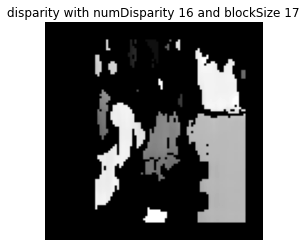

In [6]:
def main():
    video_pathL = 'robot-navigation-video/robotL.avi'
    videoL = cv2.VideoCapture(video_pathL)
    video_pathR = 'robot-navigation-video/robotR.avi'
    videoR = cv2.VideoCapture(video_pathR)

    #to play a video given in input
    #playVideoS(videoR)

    #compute disparity map and compute distance z
    computeDisparityMap(videoL, videoR)
    
if __name__ == "__main__":
    main()